<a href="https://colab.research.google.com/github/RubingLi123/foster_dev_2023/blob/2023-dev/Module8_Causality/Analytical_engieering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#If opening in colab run this cell
!git clone https://github.com/RubingLi123/foster_dev_2023
%cd foster_dev_2023/Module8_Causality/

Cloning into 'foster_dev_2023'...
remote: Enumerating objects: 1290, done.
remote: Counting objects: 100% (1290/1290), done.
remote: Compressing objects: 100% (652/652), done.
remote: Total 1290 (delta 705), reused 1132 (delta 622), pack-reused 0
Receiving objects: 100% (1290/1290), 79.71 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (705/705), done.
Updating files: 100% (120/120), done.
/content/foster_dev_2023/Module8_Causality


# Toward Analytical Engineering


Spring 2023 - Instructors: Foster Provost and Rubing Li

Teaching Assistant: Rubing Li

***

In [19]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# just ignore the warning messages for cleaner display
import warnings
warnings.filterwarnings('ignore')

matplotlib: 3.7.1


### Data
We're going to use the same mail response data set from a real direct marketing campaign as in Module 5. Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation. 

The columns (features) are:

```
income       household income
Firstdate    data assoc. with the first gift by this individual
Lastdate     data associated with the most recent gift 
rfaf2        frequency code
rfaa2        donation amount code
pepstrfl     flag indicating a star donator
glast        amount of last gift
gavr         amount of average gift
```

The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

In [3]:
# Load the data
df = pd.read_csv("donation.csv",index_col=0)
# Let's take a look at the data
df.head()

,Income,Firstdate,Lastdate,rfaf2,rfaa2,pepstrfl,glast,gavr,class,donation
0,3.886248,8911,9512,4,E,X,10.0,7.741935,0,0.0
1,6.000000,9310,9512,2,G,0,25.0,15.666667,0,0.0
2,3.000000,9001,9512,4,E,X,5.0,7.481481,0,0.0
3,1.000000,8702,9512,4,E,X,10.0,6.812500,0,0.0
4,3.000000,7903,9601,2,F,0,15.0,6.864865,0,0.0


In [4]:
# Get dummies for the two categorical variables cuz we'll run a logistic regression later.
for field in ['rfaa2', 'pepstrfl']:
    dummies = pd.get_dummies(df[field])
    dummies.columns = [field + "_" + s for s in dummies.columns]
    df = pd.concat([df, dummies], axis=1).drop(field, axis="columns")
    
df.head()

,Income,Firstdate,Lastdate,rfaf2,glast,gavr,class,donation,rfaa2_D,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_0,pepstrfl_X
0,3.886248,8911,9512,4,10.0,7.741935,0,0.0,0,1,0,0,0,1
1,6.000000,9310,9512,2,25.0,15.666667,0,0.0,0,0,0,1,1,0
2,3.000000,9001,9512,4,5.0,7.481481,0,0.0,0,1,0,0,0,1
3,1.000000,8702,9512,4,10.0,6.812500,0,0.0,0,1,0,0,0,1
4,3.000000,7903,9601,2,15.0,6.864865,0,0.0,0,0,1,0,1,0


## Charity Mailing

Previously when we were trying to solve the targeting problem, we trained a model to predict the probabiliy that each customer will respond to the offer, plotted the profit curve according to the ranking of such probabilities. Finally we chose the threshold that yields the maximum amount of donations.  

Now what if the goal is, instead to maximize the donation *profit*? Instead of ranking according to the probability of responding to the solicitation, we can rank by the expected value of targeting. With a little help from our expected value framework to decompose this problem: $\text{Expected benefit of targeting} = p(R|\textbf{x}) \cdot v_R(\textbf{x}) + [1- p(R|\textbf{x})] \cdot v_{NR}(\textbf{x})$   

- We already know how to build the model to predict $p(R|\textbf{x})$.  
- Now we also want to estimate: $v_R(\textbf{x})$, which is the value (amount of donation - solicitation cost) of customer $\textbf{x}$ if he responds to the offer. We can train a model only on customers who have responded to predict this.  
- $v_{NR}(\textbf{x})$, which is the value of customer $\textbf{x}$ if he doesn't respond to the offer, in this application we assume to be just 0 minus the colicitation cost.



In [20]:
# Split our data into training and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Set features and target variable
Y_respond = 'class'
Y_amount = 'donation'
predictors = [x for x in df.columns if x not in [Y_respond,Y_amount]]

In [23]:
def find_best(data, target, model_type, metrics, param_name, param_vals):
    aucs = list()
    for param_val in param_vals:
        model = model_type(**{param_name: param_val})
        avg_auc = cross_val_score(model, data[predictors], data[target], cv=10, scoring=metrics).mean()
        aucs.append(avg_auc)
    # Plot fitting curve
    plt.xscale('log', base=2)
    plt.plot(param_vals, aucs)
    plt.xlabel(param_name)
    plt.ylabel("Cross-Validated %s" %metrics)
    plt.title(model_type.__name__)
    plt.show()
    # Print best
    best_ix = np.argmax(aucs)
    best_auc = aucs[best_ix]
    best_param = param_vals[best_ix]
    print("Best {0} with {1}={2}. {3}: {4}".format(model_type.__name__, param_name, best_param, metrics,round(best_auc, 2)))
    return model_type(**{param_name: best_param})

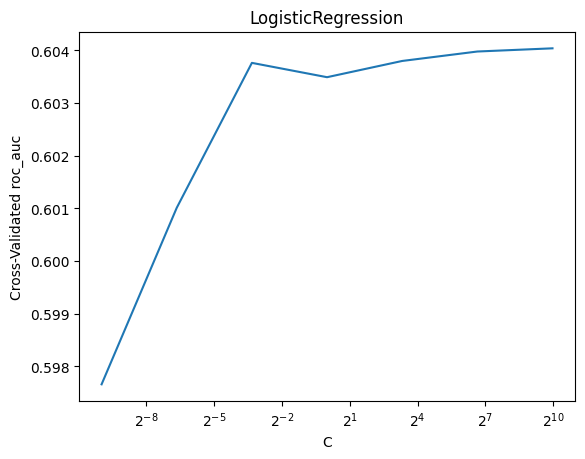

Best LogisticRegression with C=1000.0. roc_auc: 0.6


In [24]:
# find best model to predict probability of responding to solicitation
logistic_params = np.power(10.0, range(-3, 4))
best_logistic = find_best(df_train, Y_respond, LogisticRegression, 'roc_auc',"C", logistic_params)

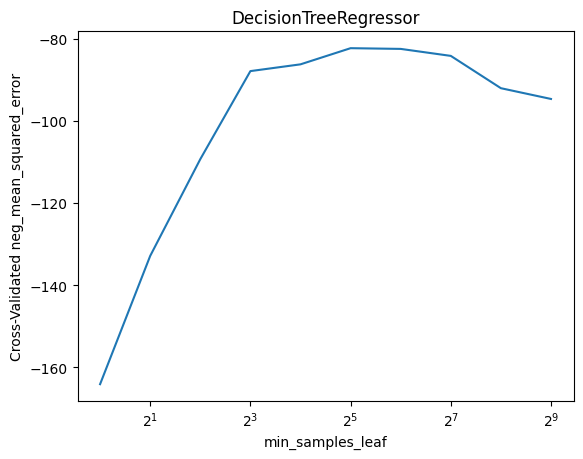

Best DecisionTreeRegressor with min_samples_leaf=32. neg_mean_squared_error: -82.3


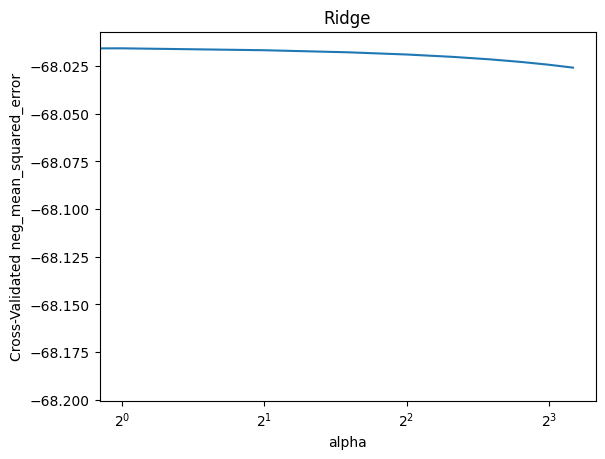

Best Ridge with alpha=1. neg_mean_squared_error: -68.02


In [25]:
# find best model to predict donation amount
tree_params = np.power(2, range(10))
best_tree = find_best(df_train[df_train['class'] == 1], Y_amount, DecisionTreeRegressor, 'neg_mean_squared_error','min_samples_leaf', tree_params)
ridge_params = np.arange(0, 10, 1)
best_regression = find_best(df_train[df_train['class'] == 1], Y_amount, Ridge, 'neg_mean_squared_error','alpha', ridge_params)

In [26]:
# function to plot profict curve
def plot_profit_curve(data, donations_best_model, probs_best_model, rank_by_probs=True):
    # Assume the cost to target each customer is constant 
    targeting_cost = 0.8
    # Get donations if responded to solicitation
    donations = donations_best_model.predict(data[predictors])
    # Offer value per customer
    offer_value = data[Y_respond] * donations - targeting_cost
    # Get probabilities of responding to solicitation
    probs = probs_best_model.predict_proba(data[predictors])[:, 1]
    #Expected value if targeting
    e_loss = probs * donations - targeting_cost
    # Rank observations (according to probability of responding to solicitation or expected loss)
    if rank_by_probs:
        order = np.argsort(probs)[::-1]
        label = "Rank by probabilities"
    else:
        order = np.argsort(e_loss)[::-1]
        label = "Rank by expected loss"
    # Build the profit curve
    total_obs = data.shape[0]
    x_cumulative = np.arange(len(probs)) + 1
    x_cumulative_scaled = np.array(x_cumulative/total_obs)*100
    profits = np.cumsum(offer_value.values[order])
    # Plot profit curve
    plt.plot(x_cumulative_scaled, profits, label=label)
    # Max profit point
    plt.plot(x_cumulative_scaled[profits.argmax(axis=0)],
                 profits[profits.argmax(axis=0)],
                 'ro')
    plt.text(x_cumulative_scaled[profits.argmax(axis=0)],
             profits[profits.argmax(axis=0)],
             "Estimated profit is %.4f." % profits[profits.argmax(axis=0)],horizontalalignment='right')
    # Other details of the plot
    plt.xlabel("Percentage of customers targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend(loc='best')


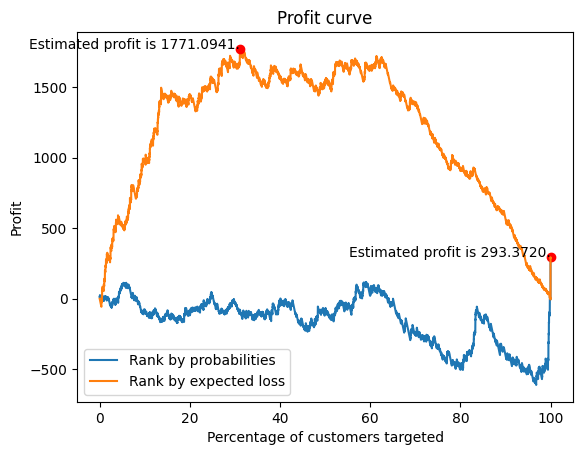

In [27]:
# Chosen Model:
donations_best_model = Ridge(alpha=1.0).fit(df_train[df_train['class'] == 1][predictors], df_train[df_train['class'] == 1][Y_amount])
probs_best_model = LogisticRegression(C = 1000).fit(df_train[predictors],df_train[Y_respond])

# plot profit curve
plot_profit_curve(df_test, donations_best_model,probs_best_model,True)
plot_profit_curve(df_test, donations_best_model,probs_best_model,False)
plt.show()